# 飞桨深度学习平台设计之“道”

当读者习惯使用飞桨框架后会发现程序呈现出“八股文”的形态，即不同的程序员、使用不同模型、解决不同任务的时候，他们编写的建模程序是极其相似的。虽然这些设计在某些“极客”的眼里缺乏精彩，但从实用性的角度，我们更期望建模者聚焦需要解决的任务，而不是将精力投入在框架的学习上。因此使用飞桨编写模型是有标准的套路设计的，只要通过一个示例程序掌握使用飞桨的方法，编写不同任务的多种建模程序将变得十分容易。

这点与Python的设计思想一致：对于某个特定功能，并不是实现方式越灵活、越多样越好，最好只有一种符合“道”的最佳实现。此处“道”指的是如何更加匹配人的思维习惯。当程序员第一次看到Python的多种应用方式时，感觉程序天然就应该如此实现。但相信我，不是所有的编程语言都具备这样合“道”的设计，很多编程语言的设计思路是人需要去理解机器的运作原理，而不能以人类习惯的方式设计程序。同时，灵活意味着复杂，会增加程序员之间的沟通难度，也不适合现代工业化生产软件的趋势。

飞桨设计的初衷不仅要易于学习，还期望使用者能够体会到它的美感和哲学，与人类最自然的认知和使用习惯契合。

# 使用飞桨构建波士顿房价预测模型

本书中的案例覆盖计算机视觉、自然语言处理和推荐系统等主流应用场景，所有案例的代码结构完全一致，如 **图1** 所示。
<br></br>
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/1c9a9b3b90b44dfdbba227098db93192aa52730d8fe647faad7c9fca1912e2c9" width="800" hegiht="" ></center>
<center><br>图1：使用飞桨框架构建神经网络过程</br></center>
<br></br>

在之前的章节中，我们学习了使用Python和Numpy构建波士顿房价预测模型的方法，本节课我们将尝试使用飞桨重写房价预测模型，大家可以体会一下二者的异同。在数据处理之前，需要先加载飞桨框架的相关类库。

In [4]:
#加载飞桨、Numpy和相关类库
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
import numpy as np
import os
import random

代码中参数含义如下：

* paddle：飞桨的主库，paddle 根目录下保留了常用API的别名，当前包括：paddle.tensor、paddle.framework目录下的所有API。

* paddle.nn：组网相关的API，例如 Linear 、卷积 Conv2D 、 循环神经网络 LSTM 、损失函数 CrossEntropyLoss 、 激活函数 ReLU 等。

* Linear：神经网络的全连接层函数，即包含所有输入权重相加的基本神经元结构。在房价预测任务中，使用只有一层的神经网络（全连接层）来实现线性回归模型。

* paddle.nn.functional：与paddle.nn一样，包含组网相关的API，例如Linear、激活函数ReLu等。两者下的同名模块功能相同，运行性能也基本一致。 但是，paddle.nn下的模块均是类，每个类下可以自带模块参数；paddle.nn.functional下的模块均是函数，需要手动传入模块计算需要的参数。在实际使用中，卷积、全连接层等层本身具有可学习的参数，建议使用paddle.nn模块，而激活函数、池化等操作没有可学习参数，可以考虑直接使用paddle.nn.functional下的函数代替。
<br></br>
------

**说明：**

飞桨支持两种深度学习建模编写方式，更方便调试的动态图模式和性能更好并便于部署的静态图模式。

* 动态图模式（命令式编程范式，类比Python）：解析式的执行方式。用户无需预先定义完整的网络结构，每写一行网络代码，即可同时获得计算结果。
* 静态图模式（声明式编程范式，类比C++）：先编译后执行的方式。用户需预先定义完整的网络结构，再对网络结构进行编译优化后，才能执行获得计算结果。

飞桨框架2.0及之后的版本，默认使用动态图模式进行编码，同时提供了全面完备的动转静支持。开发者仅需添加一个装饰器（ to_static ），飞桨会自动将动态图的程序，转换为静态图的program，并使用该program训练并可保存静态模型以实现推理部署。

------

## 数据处理

数据处理的代码不依赖框架实现，与使用Python构建房价预测任务的代码相同，详细解读请参考《使用Python和Numpy构建神经网络模型》章节，这里不再赘述。

In [5]:
def load_data():
    # 从文件导入数据
    datafile = './work/housing.data'
    data = np.fromfile(datafile, sep=' ', dtype=np.float32)

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', \
                      'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)

    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算train数据集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
                                 training_data.sum(axis=0) / training_data.shape[0]
    
    # 记录数据的归一化参数，在预测时对数据做归一化
    global max_values
    global min_values
    global avg_values
    max_values = maximums
    min_values = minimums
    avg_values = avgs

    # 对数据进行归一化处理
    for i in range(feature_num):
        data[:, i] = (data[:, i] - avgs[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data


## 模型设计

模型定义的实质是定义线性回归的网络结构，飞桨建议通过创建Python类的方式完成模型网络的定义，该类需要继承paddle.nn.Layer父类，并且在类中定义``init``函数和``forward``函数。``forward``函数是框架指定实现前向计算逻辑的函数，程序在调用模型实例时会自动执行forward方法。在``forward``函数中使用的网络层需要在``init``函数中声明。

实现过程分如下两步：

1. **定义init函数**：在类的初始化函数中声明每一层网络的实现函数。在房价预测模型中，只需要定义一层全连接层，模型结构和使用Python和Numpy构建神经网络模型》章节模型保持一致。
1. **定义forward函数**：构建神经网络结构，实现前向计算过程，并返回预测结果，在本任务中返回的是房价预测结果。


In [6]:
class Regressor(paddle.nn.Layer):

    # self代表类的实例自身
    def __init__(self):
        # 初始化父类中的一些参数
        super(Regressor, self).__init__()
        
        # 定义两层全连接层
        self.fc1 = Linear(in_features=13, out_features=7)
        self.fc2 = Linear(in_features=7, out_features=1)
    
    # 网络的前向计算
    def forward(self, inputs):
        x = self.fc1(inputs)
        x = self.fc2(x)
        return x

## 训练配置

训练配置过程包含四步，如 **图2** 所示：
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/96075d4df5ae4e01ac1491ebf176fa557bd122b646ba49238f65c9b38a98cab4" width="700" hegiht="" ></center>
<center><br>图2：训练配置流程示意图</br></center>
<br></br>

1. 声明定义好的回归模型Regressor实例，并将模型的状态设置为训练。
1. 使用load_data函数加载训练数据和测试数据。
1. 设置优化算法和学习率，优化算法采用随机梯度下降SGD，学习率设置为0.01。

训练配置代码如下所示：

In [7]:
# 声明定义好的线性回归模型
model = Regressor()
# 开启模型训练模式
model.train()
# 加载数据
training_data, test_data = load_data()
# 定义优化算法，使用随机梯度下降SGD
# 学习率设置为0.001
opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())

------

**说明：**

模型实例有两种状态：训练状态``.train()``和预测状态``.eval()``。训练时要执行正向计算和反向传播梯度两个过程，而预测时只需要执行正向计算，为模型指定运行状态，有两点原因：

1. 部分高级的算子（例如Dropout和BatchNorm，在计算机视觉的章节会详细介绍）在两个状态执行的逻辑不同；
1. 从性能和存储空间的考虑，预测状态时更节省内存(无需记录反向梯度)，性能更好。

------

在基于Python实现神经网络模型的案例中，我们为实现梯度下降编写了大量代码，而使用飞桨框架只需要定义SGD就可以实现优化器设置，大大简化了这个过程。

## 训练过程

训练过程采用二层循环嵌套方式：

- **内层循环：** 负责整个数据集的一次遍历，采用分批次方式（batch）。假设数据集样本数量为1000，一个批次有10个样本，则遍历一次数据集的批次数量是1000/10=100，即内层循环需要执行100次。

        for iter_id, mini_batch in enumerate(mini_batches):

- **外层循环：** 定义遍历数据集的次数，通过参数EPOCH_NUM设置。

        for epoch_id in range(EPOCH_NUM):

------
**说明**:

batch的取值会影响模型训练效果。batch过大，会增大内存消耗和计算时间，且训练效果并不会明显提升（因为每次参数只向梯度反方向移动一小步，所以方向没必要特别精确）；batch过小，每个batch的样本数据将没有统计意义，计算的梯度方向可能偏差较大。由于房价预测模型的训练数据集较小，我们将batch为设置10。

------

每次内层循环都需要执行如下四个步骤，如 **图3** 所示，计算过程与使用Python编写模型完全一致。
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/8154cf612a024a3f9144b4e31f59568ef9ad59c155b344919221d63bb9ccfcc8" width="700" hegiht="" ></center>
<center><br>图3：内循环计算过程</br></center>
<br></br>

1. 数据准备：将一个批次的数据先转换成np.array格式，再转换成paddle内置tensor格式。
1. 前向计算：将一个批次的样本数据灌入网络中，计算输出结果。
1. 计算损失函数：以前向计算结果和真实房价作为输入，通过损失函数square_error_cost API计算出损失函数值（Loss）。飞桨所有的API接口都有完整的说明和使用案例，在后续教程中我们会详细介绍API的查阅方法。
1. 反向传播：执行梯度反向传播``backward``函数，即从后到前逐层计算每一层的梯度，并根据设置的优化算法更新参数。

In [8]:
EPOCH_NUM = 50   # 设置外层循环次数
BATCH_SIZE = 100  # 设置batch大小

# 定义外层循环
for epoch_id in range(EPOCH_NUM):
    # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
    np.random.shuffle(training_data)
    # 将训练数据进行拆分，每个batch包含100条数据
    mini_batches = [training_data[k:k+BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]
    # 定义内层循环
    for iter_id, mini_batch in enumerate(mini_batches):
        x = np.array(mini_batch[:, :-1]) # 获得当前批次训练数据
        y = np.array(mini_batch[:, -1:]) # 获得当前批次训练标签（真实房价）
        # 将numpy数据转为飞桨动态图tensor形式
        house_features = paddle.to_tensor(x)
        prices = paddle.to_tensor(y)
        
        # 前向计算
        predicts = model(house_features)
        
        # 计算损失
        loss = F.square_error_cost(predicts, label=prices)
        avg_loss = paddle.mean(loss)
        if iter_id%20==0:
            print("epoch: {}, iter: {}, loss is: {}".format(epoch_id, iter_id, avg_loss.numpy()))
        
        # 反向传播
        avg_loss.backward()
        # 最小化loss,更新参数
        opt.step()
        # 清除梯度
        opt.clear_grad()


epoch: 0, iter: 0, loss is: [0.11339398]
epoch: 0, iter: 20, loss is: [0.05923703]
epoch: 0, iter: 40, loss is: [0.12417271]
epoch: 1, iter: 0, loss is: [0.20706148]
epoch: 1, iter: 20, loss is: [0.10208128]
epoch: 1, iter: 40, loss is: [0.07414114]
epoch: 2, iter: 0, loss is: [0.09584296]
epoch: 2, iter: 20, loss is: [0.02603794]
epoch: 2, iter: 40, loss is: [0.10170087]
epoch: 3, iter: 0, loss is: [0.05859667]
epoch: 3, iter: 20, loss is: [0.05384312]
epoch: 3, iter: 40, loss is: [0.06947085]
epoch: 4, iter: 0, loss is: [0.02522727]
epoch: 4, iter: 20, loss is: [0.03373599]
epoch: 4, iter: 40, loss is: [0.00527195]
epoch: 5, iter: 0, loss is: [0.09216032]
epoch: 5, iter: 20, loss is: [0.04403526]
epoch: 5, iter: 40, loss is: [0.07605968]
epoch: 6, iter: 0, loss is: [0.05471449]
epoch: 6, iter: 20, loss is: [0.01680253]
epoch: 6, iter: 40, loss is: [0.10930893]
epoch: 7, iter: 0, loss is: [0.01835149]
epoch: 7, iter: 20, loss is: [0.01899629]
epoch: 7, iter: 40, loss is: [0.02796026]


这个实现过程令人惊喜，前向计算、计算损失和反向传播梯度，每个操作居然只有1-2行代码即可实现！框架内部帮我们自动实现反向梯度计算和参数更新的过程，我们再也不用一点点的实现模型训练的细节，这就是使用飞桨框架的威力！

## 保存并测试模型

### 保存模型

将模型当前的参数数据``model.state_dict()``保存到文件中（通过参数指定保存的文件名 LR_model），以备预测或校验的程序调用，代码如下所示。

In [9]:
# 保存模型参数，文件名为LR_model.pdparams
paddle.save(model.state_dict(), 'LR_model.pdparams')
print("模型保存成功，模型参数保存在LR_model.pdparams中")

模型保存成功，模型参数保存在LR_model.pdparams中


理论而言，直接使用模型实例即可完成预测，而本教程中预测的方式为什么是先保存模型，再加载模型呢？这是因为在实际应用中，训练模型和使用模型往往是不同的场景。模型训练通常使用大量的线下服务器（不对外向企业的客户/用户提供在线服务），而模型预测则通常使用线上提供预测服务的服务器，或者将已经完成的预测模型嵌入手机或其他终端设备中使用。因此本教程的讲解方式更贴合真实场景的使用方法。

回顾下基于飞桨实现的房价预测模型，实现效果与之前基于Python实现的模型没有区别，但两者的实现成本有天壤之别。飞桨的愿景是用户只需要了解模型的逻辑概念，不需要关心实现细节，就能搭建强大的模型。

### 测试模型

下面我们选择一条数据样本，测试下模型的预测效果。测试过程和在应用场景中使用模型的过程一致，主要可分成如下三个步骤：

1. 配置模型预测的机器资源。本案例默认使用本机，因此无需写代码指定。
1. 将训练好的模型参数加载到模型实例中。由两个语句完成，第一句是从文件中读取模型参数；第二句是将参数内容加载到模型。加载完毕后，需要将模型的状态调整为``eval()``（校验）。上文中提到，训练状态的模型需要同时支持前向计算和反向传导梯度，模型的实现较为臃肿，而校验和预测状态的模型只需要支持前向计算，模型的实现更加简单，性能更好。
1. 将待预测的样本特征输入到模型中，打印输出的预测结果。

通过``load_one_example``函数实现从数据集中抽一条样本作为测试样本，具体实现代码如下所示。

In [16]:
def load_one_example():
    # 从上边已加载的测试集中，随机选择一条作为测试数据
    idx = np.random.randint(0, test_data.shape[0])
    one_data, label = test_data[idx, :-1], test_data[idx, -1]
    # 修改该条数据shape为[1,13]
    one_data =  one_data.reshape([1,-1])

    return one_data, label


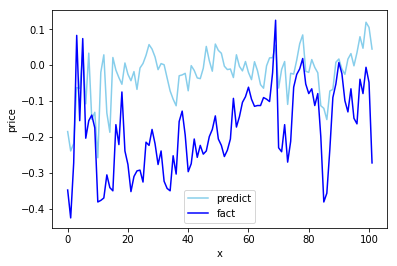

Inference result is [[21.08424]], the corresponding label is 17.200000762939453


In [23]:
import matplotlib.pyplot as plt
# 参数为保存模型参数的文件地址
model_dict = paddle.load('LR_model.pdparams')
model.load_dict(model_dict)
model.eval()
#预测
x = test_data[:, :-1]
y = test_data[:, -1:]
x = paddle.to_tensor(x)
Y=model(x)
Y=Y.numpy()

plt.plot(np.arange(len(x)), Y,  color='skyblue', label='predict')
plt.plot(np.arange(len(x)), y, color='blue', label='fact')
plt.legend()
 
plt.xlabel('x')
plt.ylabel('price')
plt.show()
one_data, label = load_one_example()
# 将数据转为动态图的variable格式 
one_data = paddle.to_tensor(one_data)
predict = model(one_data)

# 对结果做反归一化处理
predict = predict * (max_values[-1] - min_values[-1]) + avg_values[-1]
# 对label数据做反归一化处理
label = label * (max_values[-1] - min_values[-1]) + avg_values[-1]

print("Inference result is {}, the corresponding label is {}".format(predict.numpy(), label))

通过比较“模型预测值”和“真实房价”可见，模型的预测效果与真实房价接近。房价预测仅是一个最简单的模型，使用飞桨编写均可事半功倍。那么对于工业实践中更复杂的模型，使用飞桨节约的成本是不可估量的。同时飞桨针对很多应用场景和机器资源做了性能优化，在功能和性能上远强于自行编写的模型。

从下一章开始，我们将通过“手写数字识别”的案例，完整掌握使用飞桨编写模型的方方面面。

### 作业1-6

1. 在[AI Studio](http://aistudio.baidu.com/)上阅读房价预测案例（两个版本）的代码，并运行观察效果。
1. 在本机或服务器上安装Python、jupyter和PaddlePaddle，运行房价预测的案例（两个版本），并观察运行效果。
1. 想一想：基于Python编写的模型和基于飞桨编写的模型在存在哪些异同？如程序结构，编写难易度，模型的预测效果，训练的耗时等等。